In [2]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# Aggregating

This section introduces operations for aggregating rows in a relation. Data
scientists aggregate rows together to make summaries of data. For instance, a
dataset containing daily sales can be aggregated to show monthly sales instead.
Specifically, we'll introduce *grouping*, a common operation for aggregating
data.

We'll work with the baby names data, as introduced in the previous section:

In [4]:
# Set up connection to database
import sqlalchemy
db = sqlalchemy.create_engine('sqlite:///babynames.db')

In [5]:
query = ''' 
SELECT *
FROM baby
LIMIT 10
'''

pd.read_sql(query, db)

,Name,Sex,Count,Year
0,Liam,M,19659,2020
1,Noah,M,18252,2020
2,Oliver,M,14147,2020
...,...,...,...,...
7,Lucas,M,11281,2020
8,Henry,M,10705,2020
9,Alexander,M,10151,2020


## Basic Group-Aggregate

Let's say you want to find out the total number of babies born as recorded in
this data. This is simply the sum of the `Count` column. SQL provides
functions that we use in the `SELECT` statement, like `SUM`:

In [8]:
query = ''' 
SELECT SUM(Count)
FROM baby
'''

pd.read_sql(query, db)

,SUM(Count)
0,352554503


Summing up the name counts is one simple way to aggregate the data---it
combines data from multiple rows.

But let's say you instead want to answer a more interesting question: are U.S.
births trending upwards over time? To answer this question, you can sum the
`Count` column within each year rather than taking the sum over the entire
dataset. In other words, you can split the data into groups based on `Year`,
then sum up the `Count` values within each group.

```{figure} figures/sql-groupby-births.svg
---
name: sql-groupby-births
alt: sql-groupby-births
---
A depiction of grouping then aggregating for example data.
```

We call this operation **grouping** followed by **aggregating**. In SQL, we
specify what column we wish to use for grouping through the `GROUP BY` clause,
then using aggregation functions in `SELECT`:

In [12]:
query = ''' 
SELECT Year, SUM(Count)
FROM baby
GROUP BY Year
'''

pd.read_sql(query, db)

,Year,SUM(Count)
0,1880,194419
1,1881,185772
2,1882,213385
...,...,...
138,2018,3487193
139,2019,3437438
140,2020,3287724


Notice that the code is nearly the same as the non-grouped version, except that
it contains a `GROUP BY` clause using the `Year` column. We also add the `Year`
column to the `SELECT` clause so that each row of the result also contains the
year.

The result is a relation with the total babies born for each year in the data.
Notice that the Year column contains the unique `Year` values---there are no
duplicate `Year` values anymore since we grouped them together. Now we can plot
the counts over time:

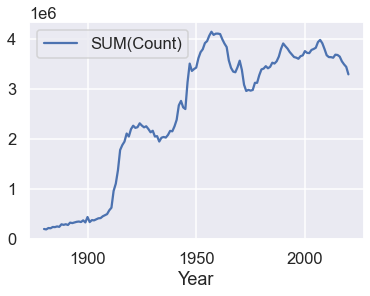

In [14]:
counts_by_year = pd.read_sql(query, db)
counts_by_year.plot('Year', 'SUM(Count)');

What do you see in this plot? First, you might notice that there seem to be
suspiciously few babies born before 1920. One likely explanation is that the
Social Security Administration was created in 1935, so its data for prior
births could be less complete.

You might also notice the dip when World War II began in 1939, and the
post-war Baby Boomer era from 1946-1964.

Here's the basic recipe for grouping in `SQL`:

```sql
SELECT
  col1,           -- column used for grouping
  SUM(col2)       -- aggregation of another column
FROM table_name   -- relation to use
GROUP BY col1     -- the column(s) to group by
```

## Grouping on Multiple Columns

You can pass multiple columns into `GROUP BY` to group by multiple columns at
once. This is useful when you need to further subdivide your groups. For
example, we can group by both year and sex to see how many male and female
babies were born over time.

In [15]:
query = ''' 
SELECT Year, Sex, SUM(Count)
FROM baby
GROUP BY Year, Sex
'''

pd.read_sql(query, db)

,Year,Sex,SUM(Count)
0,1880,F,83929
1,1880,M,110490
2,1881,F,85034
...,...,...,...
279,2019,M,1785527
280,2020,F,1581301
281,2020,M,1706423


Notice how the code closely follows the grouping recipe.

## Other Aggregation Functions

The SQLite database has several other built-in aggregation functions, such as
`COUNT`, `AVG`, `MIN`, and `MAX`. The full list of functions is available on
the SQLite website [^agg_funcs].

[^agg_funcs]: https://www.sqlite.org/lang_aggfunc.html

We've already seen the `SUM` function:

In [16]:
query = ''' 
SELECT Year, SUM(Count)
FROM baby
GROUP BY Year
'''

pd.read_sql(query, db)

,Year,SUM(Count)
0,1880,194419
1,1881,185772
2,1882,213385
...,...,...
138,2018,3487193
139,2019,3437438
140,2020,3287724


To use another aggregation function, we call it in the `SELECT` clause. For
instance, we can use `MAX` instead of `SUM`:

In [18]:
query = ''' 
SELECT Year, MAX(Count)
FROM baby
GROUP BY Year
'''

pd.read_sql(query, db)

,Year,MAX(Count)
0,1880,9655
1,1881,8769
2,1882,9557
...,...,...
138,2018,19924
139,2019,20555
140,2020,19659


:::{note}

The available aggregation functions are one of the first places a data
scientist may encounter differences in SQL implementations. For instance,
SQLite has a relatively minimal set of aggregation functions, while PostgreSQL
has many more [^pg_agg_funcs]. Most SQL implementations provide `SUM`, `COUNT`,
`MIN`, `MAX`, and `AVG`.

:::

[^pg_agg_funcs]: https://www.postgresql.org/docs/current/functions-aggregate.html

## Example: Have People Become More Creative With Baby Names?

Have people become more creative with baby names over time? One way to measure
this is to see whether the number of *unique* baby names per year has increased
over time.

To do this aggregation in SQL, we use the `COUNT` function and the `DISTINCT`
keyword. The `DISTINCT` keyword tells SQL to only keep the unique values within
a set of columns.

In [26]:
# Finds the unique baby names
query = ''' 
SELECT DISTINCT Name
FROM baby
'''

pd.read_sql(query, db)

,Name
0,Liam
1,Noah
2,Oliver
...,...
100361,Crete
100362,Roll
100363,Zilpah


To count the number of distinct names, we can aggregate using the `COUNT`
function. We'll also use the `AS` keyword to rename the resulting column.

In [28]:
# Finds the number of unique baby names
query = ''' 
SELECT COUNT(DISTINCT Name) as n_names
FROM baby
'''

pd.read_sql(query, db)

,n_names
0,100364


Finally, we group by the `Year` column to aggregate over each year rather than
over the entire dataset:

In [23]:
query = ''' 
SELECT Year, COUNT(DISTINCT Name) AS n_names
FROM baby
GROUP BY Year
'''

unique_names_by_year = pd.read_sql(query, db)
unique_names_by_year

,Year,n_names
0,1880,1889
1,1881,1829
2,1882,2012
...,...,...
138,2018,29619
139,2019,29417
140,2020,28613


Now, we can plot the number of unique names over time: 

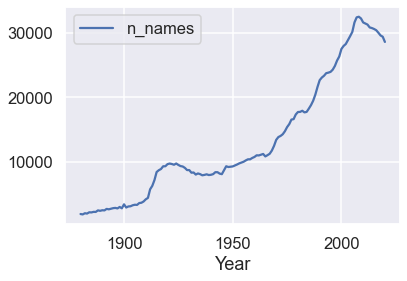

In [29]:
unique_names_by_year.plot('Year', 'n_names');

We see that the number of unique names has generally increased over time, even
though the number of babies born has mostly stabilized since the 1960s.

:::{note}

Unlike `pandas`, SQLite doesn't provide a simple way to pivot a relation.
Instead, we use `GROUP BY` on two columns in SQL, read the result into a
dataframe, and then use the `unstack()` dataframe method [^unstack].

:::

[^unstack]: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.unstack.html